In [31]:
using Distributions
using LinearAlgebra
using StatsFuns
using StatsBase

using LogDensityProblems
using LogDensityProblemsAD
using AbstractDifferentiation
using MCMCDiagnosticTools
using AdvancedHMC
using MicroCanonicalHMC
using Pathfinder
using Transducers

using Healpix
using HealpixMPI
using MPI

using Plots
using StatsPlots
using LaTeXStrings

using Random
using ProgressMeter
using BenchmarkTools
using NPZ
using CSV
using DataFrames
using Test

using Zygote: @adjoint
using Zygote
using ChainRules.ChainRulesCore

include("AD_parallSHT.jl")
include("gen_datatest.jl")
include("reparam.jl")
include("utils.jl")
include("inference_model.jl")
include("neglogproblem.jl")

nℓπ_grad (generic function with 1 method)

In [32]:
seed = 1123
Random.seed!(seed)

#   RESOLUTION PARAMETERS
nside = 64
lmax = 2*nside - 1

MPI.Init()

comm = MPI.COMM_WORLD
crank = MPI.Comm_rank(comm)
csize = MPI.Comm_size(comm)
root = 0
ncore = 8

8

In [33]:
#   REALIZATION MAP
realiz_Cl, realiz_HAlm, realiz_HMap = Realization("Capse_fiducial_Dl.csv", nside, lmax, seed)
realiz_θ = vcat(x_vecmat2vec(from_healpix_alm_to_alm([realiz_HAlm], lmax, 1, comm, root=root), lmax, 1, comm, root=root), Cl2Kl(realiz_Cl))

d = length(realiz_θ)

#   SURVEY MASK
mask_512 = readMapFromFITS("wmap_temperature_kq85_analysis_mask_r9_9yr_v5.fits",2,Float64)
mask_nside = udgrade(nest2ring(mask_512), nside)
for i in 1:length(mask_nside.pixels)
    if mask_nside.pixels[i]<=0.5
        mask_nside.pixels[i]=1
    else
        mask_nside.pixels[i]=0
    end
end

#   GENERATED DATA MEASUREMENTS
#   Noise
ϵ=100
N = ϵ*ones(nside2npix(nside))
N[mask_nside.==1] .= 5*10^4
#   Gaussian beam and pixel window function
Bl = gaussbeam(0.001, lmax, pol=false)
Pl = pixwin(nside, pol=false)[1:lmax+1]
BP_l = Bl.*Pl

#   Data Map
gen_Cl, gen_HAlm, gen_HMap = Measurement(realiz_Cl, Bl, Pl, mask_nside, N, nside, lmax, seed)
gen_θ = vcat(x_vecmat2vec(from_healpix_alm_to_alm([gen_HAlm], lmax, 1, comm, root=root), lmax, 1, comm, root=root), Cl2Kl(gen_Cl))
invN_HMap = HealpixMap{Float64,RingOrder}(1 ./ N)

#   STARTING POINT
start_Cl, start_HAlm, start_HMap = StartingPoint(gen_Cl, nside)
start_θ = vcat(x_vecmat2vec(from_healpix_alm_to_alm([start_HAlm], lmax, 1, comm, root=root), lmax, 1, comm, root=root), Cl2Kl(start_Cl))

#   PROMOTE HEALPIX.MAP TO HEALIPIXMPI.DMAP
gen_DMap = DMap{RR}(comm)
invN_DMap = DMap{RR}(comm)
HealpixMPI.Scatter!(gen_HMap, gen_DMap, comm, clear=true)
HealpixMPI.Scatter!(invN_HMap, invN_DMap, comm, clear=true)

helper_DMap = deepcopy(gen_DMap)

DMap{RR, Float64}([0.0; 0.0; … ; -29.5333662949324; 39.83143130841929;;], GeomInfoMPI(MPI.Comm(1140850688), 64, 256, [1.5707963267948966, 1.5603794717389192, 1.581213181850874, 1.5499614861262483, 1.5916311674635448, 1.5395412382954015, 1.6020514152943917, 1.5291175943723188, 1.6124750592174744, 1.5186894171565548  …  0.06379961522501076, 3.0777930383647822, 0.05103657515266638, 3.090556078437127, 0.038275613631490575, 3.1033170399583025, 0.02551621035741883, 3.1160764432323744, 0.012757845597670932, 3.128834807992122], [128, 127, 129, 126, 130, 125, 131, 124, 132, 123  …  5, 251, 4, 252, 3, 253, 2, 254, 1, 255], [1, 257, 513, 769, 1025, 1281, 1537, 1793, 2049, 2305  …  49033, 49053, 49073, 49089, 49105, 49117, 49129, 49137, 49145, 49149], [256, 256, 256, 256, 256, 256, 256, 256, 256, 256  …  20, 20, 16, 16, 12, 12, 8, 8, 4, 4], [1.5707963267948966, 1.5603794717389192, 1.581213181850874, 1.5499614861262483, 1.5916311674635448, 1.5395412382954015, 1.6020514152943917, 1.5291175943723188,

In [34]:
nlp = nℓπ(start_θ, data=gen_DMap, helper_DMap=helper_DMap, lmax=lmax, nside=nside, BP_l=Bl.*Pl, invN=invN_DMap, ncore=ncore, comm=comm, root=root)
nlp_grad = nℓπ_grad(start_θ, data=gen_DMap,  helper_DMap=helper_DMap, lmax=lmax, nside=nside, BP_l=Bl.*Pl, invN=invN_DMap, ncore=ncore, comm=comm, root=root)

([-491.2012235040654, -192.1607408158456, 580.1311357436705, 378.2489314600436, 581.1417987724362, 1280.9723304080524, 69.79236147308815, -406.1980543068391, -563.0499233632709, -492.7526785747748  …  -3.3242922679408675, -3.2692186665718563, -3.255343871086419, -3.2604127117218806, -3.311583610319587, -3.3353792635154225, -3.3299944271566866, -3.2412291299059968, -3.2960284720017716, -3.228900437433352],)

In [35]:
j=6
e=zeros(d)
e[j]+=0.0001
(nℓπ(start_θ+e)-nℓπ(start_θ-e))/0.0002

1280.9723266400397

In [36]:
nlp_grad[1][j]

1280.9723304080524

In [37]:
## BENCHMARKING POSTERIOR and POSTERIOR+GRADIENTS TIMINGS
MPI.Barrier(comm)
nlp_bm = @benchmark nℓπ(start_θ)

BenchmarkTools.Trial: 2986 samples with 1 evaluation.
 Range (min … max):  1.356 ms … 182.376 ms  ┊ GC (min … max):  0.00% … 97.88%
 Time  (median):     1.417 ms               ┊ GC (median):     0.00%
 Time  (mean ± σ):   1.670 ms ±   3.349 ms  ┊ GC (mean ± σ):  12.49% ± 15.04%

  ▃█▇▅▄▃▂▁                                        ▂▂▃▂▁       ▁
  █████████▆▅▃▁▃▃▄▄▁▃▃▃▅▃▃▁▃▄▃▃▆▁▃▃▃▁▃▁▄▁▃▁▃▃▃▄▁▄████████▆▆▅▆ █
  1.36 ms      Histogram: log(frequency) by time      2.92 ms <

 Memory estimate: 5.26 MiB, allocs estimate: 25647.

In [38]:
MPI.Barrier(comm)
nlp_grad_bm = @benchmark nℓπ_grad(start_θ)

BenchmarkTools.Trial: 1424 samples with 1 evaluation.
 Range (min … max):  3.012 ms …   7.143 ms  ┊ GC (min … max):  0.00% … 27.19%
 Time  (median):     3.136 ms               ┊ GC (median):     0.00%
 Time  (mean ± σ):   3.506 ms ± 620.037 μs  ┊ GC (mean ± σ):  10.03% ± 12.64%

   ▃█▃                                                         
  ▃████▆▄▃▃▃▂▂▂▂▂▁▁▂▁▂▁▁▂▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▂▂▁▁▂▂▃▄▄▄▄▅▄▃▃▃▂▂▂▂▂ ▃
  3.01 ms         Histogram: frequency by time        4.71 ms <

 Memory estimate: 12.37 MiB, allocs estimate: 52798.

In [39]:
struct PF_LogTargetDensity
    dim::Int
end
LogDensityProblems.capabilities(::Type{PF_LogTargetDensity}) = LogDensityProblems.LogDensityOrder{1}()
LogDensityProblems.dimension(p::PF_LogTargetDensity) = p.dim
LogDensityProblems.logdensity(p::PF_LogTargetDensity, θ) = -nℓπ(θ)

PF_problem = ADgradient(:Zygote, PF_LogTargetDensity(d))

PF_seed = rand(1:10_000)
Random.seed!(PF_seed)
#PFinit_θ = Vector{Vector{Float64}}(undef, 5)
#for i in 1:5
#    PFinit_θ[i] = rand(MvNormal(start_θ,I))
#end
PFinit_θ = rand(MvNormal(start_θ,0.1*I))
MPI.Barrier(comm)
t0 = time()
result = pathfinder(PF_problem, ndraws=10, init=PFinit_θ)
PF_t = time()-t0

┌ Warning: 245 (24.5%) updates to the inverse Hessian estimate were rejected to keep it positive definite.
└ @ Pathfinder /Users/andreacrespi/.julia/packages/Pathfinder/4DR9L/src/singlepath.jl:224


37.07425403594971

In [40]:
result.draws

16512×10 Matrix{Float64}:
   8.25178      7.9161       7.68896    …    7.96397       7.97097
   0.173446     0.0988326   -0.0617029       0.00675055    0.0430153
  -2.97603     -3.08868     -3.38307        -2.95248      -3.52311
  -2.16342     -2.16609     -2.19167        -2.06242      -2.20604
 -18.8807     -18.3951     -18.8083        -18.4606      -18.3902
 -19.2072     -18.6446     -18.8331     …  -18.9674      -18.6262
   2.27195      2.26996      1.90132         1.95462       1.76226
  -0.0172743    0.237939    -0.543757        0.484977     -0.140873
  14.791       14.6258      14.3959         14.3676       14.5679
  14.0276      13.7298      13.775          13.7546       14.0147
   ⋮                                    ⋱                
  -3.22302     -3.22341     -3.21371        -3.19322      -3.24349
  -3.14337     -3.10695     -3.0735         -3.11085      -3.16181
  -3.20286     -3.07726     -3.14793    …   -3.10534      -3.15204
  -3.13815     -3.12472     -3.12974        -3

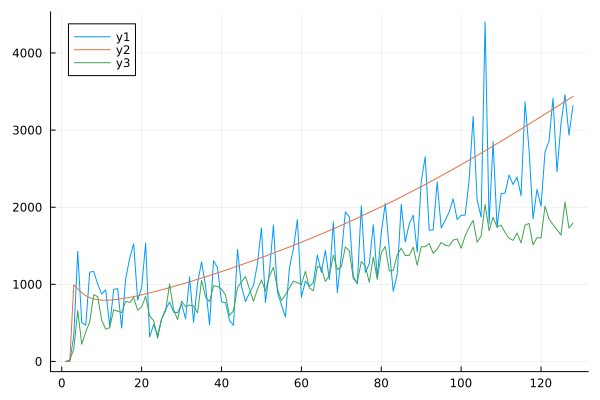

In [41]:
plot(cl2dl(Kl2Cl(result.draws[end-lmax:end,end], comm, root=0), 0))
plot!(cl2dl(realiz_Cl,0))
plot!(cl2dl(gen_Cl, 0))

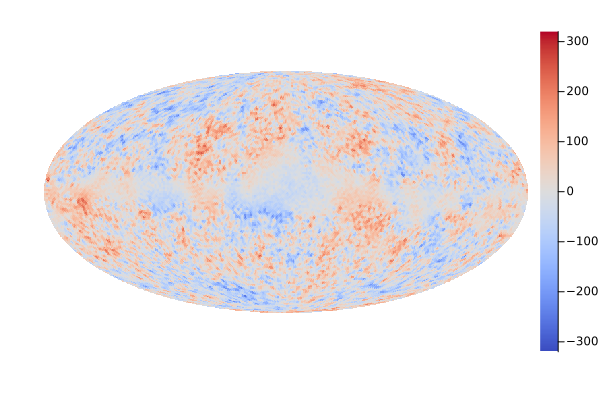

In [42]:
plot(Healpix.alm2map(from_alm_to_healpix_alm(x_vec2vecmat(result.draws[1:end-lmax-1,end], lmax, 1), lmax, 1)[1], nside), color=:coolwarm,
clim=(-320,320))

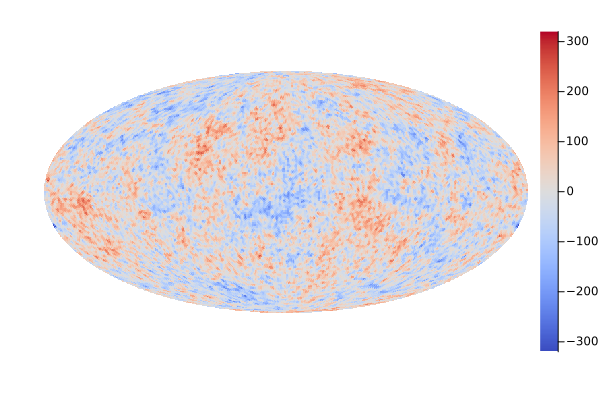

In [43]:
plot(realiz_HMap, color=:coolwarm, clim=(-320,320))

In [44]:
PF_start_θ = result.draws[:,end]
function MCHMCℓπ(θ)
    return -nℓπ(θ) #ricorda -1
end

function MCHMCℓπ_grad(x)
    f, df = nℓπ(x), nℓπ_grad(x) #ricorda -1
    return -f, -df[1]
end

MCHMCℓπ_grad (generic function with 1 method)

In [45]:
target = CustomTarget(MCHMCℓπ, MCHMCℓπ_grad, PF_start_θ)

n_adapts, n_steps = 2_000, 10_000
spl = MicroCanonicalHMC.MCHMC(n_adapts, 0.001, integrator="LF", 
            adaptive=true, tune_eps=true, tune_L=false, eps=10.0, tune_sigma=false, L=sqrt(d), sigma=ones(d))

MicroCanonicalHMC.MCHMCSampler(2000, 0.001, true, true, false, false, MicroCanonicalHMC.Hyperparameters{Float64}(10.0, 128.49902723367208, [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 0.0, 0.0, 0.0), MicroCanonicalHMC.Leapfrog)

In [46]:
MPI.Barrier(comm)
t0 = time()
samples_MCHMC = Sample(spl, target, n_steps, init_params=PF_start_θ, dialog=true, thinning=2)
MPI.Barrier(comm)
MCHMC_t = time() - t0

┌ Info: Using provided init_params
└ @ MicroCanonicalHMC /Users/andreacrespi/.julia/packages/MicroCanonicalHMC/taLUn/src/sampler.jl:256
┌ Info: Tuning eps ⏳
└ @ MicroCanonicalHMC /Users/andreacrespi/.julia/packages/MicroCanonicalHMC/taLUn/src/tuning.jl:3
Tuning:   0%|▏                                          |  ETA: 0:00:51


Tuning:   1%|▎                                          |  ETA: 0:00:38


Tuning:   1%|▍                                          |  ETA: 0:00:40


Tuning:   1%|▌                                          |  ETA: 0:00:40


Tuning:   2%|▋                                          |  ETA: 0:00:41


Tuning:   2%|▊                                          |  ETA: 0:00:41


Tuning:   2%|▉                                          |  ETA: 0:00:45


Tuning:   2%|█                                          |  ETA: 0:00:44


Tuning:   3%|█▎                                         |  ETA: 0:00:38


Tuning:   4%|█▌                                         |  ETA: 0:00:34


Tunin

119.73807501792908

In [47]:
MCHMC_ess, MCHMC_rhat = Summarize(samples_MCHMC')

([14.561042940851795, 22.88848954382613, 15.806423786818108, 16.762590012327426, 13.49766731847363, 17.0507682136732, 35.64954027756388, 19.52478517806632, 15.681228415448079, 20.99337351169221  …  1597.6132505504768, 1530.5494301464992, 1438.4552642124256, 2591.4662813680857, 3367.8698749632663, 6065.147764298084, 6518.823409103142, 179.01004743228683, 3351.8674288344964, 1679.1512171729623], [1.3416788387992507, 1.0024520532572754, 1.2886204693042278, 1.010423316917305, 1.412225372027791, 1.1197787215171289, 1.0061685005218488, 1.0460768952510417, 1.1937302162472299, 1.0000765799587108  …  1.0037359380222008, 0.9999666044290898, 1.0030815142231895, 1.000476803107012, 1.0057469745591623, 1.0050262276697213, 1.0062522278595651, 1.0013125739303923, 0.9998618756684498, 1.00046779930649])

In [51]:
5000/mean(MCHMC_ess[1:end-3])

26.12882326551846

In [16]:
MCHMC_map = Healpix.alm2map(from_alm_to_healpix_alm(x_vec2vecmat(mean(samples_MCHMC[1:end-3-lmax-1,:], dims=2), lmax, 1), lmax, 1)[1], nside);

In [83]:
MCHMC_maps_vec = Vector(undef, 5_000)
for i in 1:5_000
    MCHMC_alm_i = x_vec2vecmat(vec(samples_MCHMC[1:end-lmax-4,i]), lmax, 1)
    MCHMC_maps_vec[i] = deepcopy(Healpix.alm2map(from_alm_to_healpix_alm(MCHMC_alm_i, lmax, 1)[1], nside))
end

In [84]:
s = std(MCHMC_maps_vec);

In [85]:
res = (MCHMC_map.pixels.-realiz_HMap.pixels)./s;

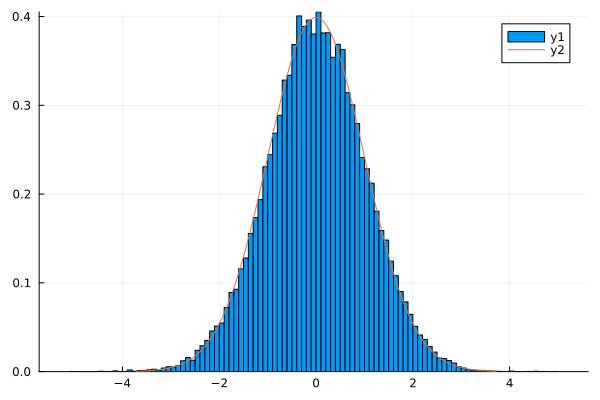

In [86]:
histogram(res, normalize=:pdf)
plot!(Normal())

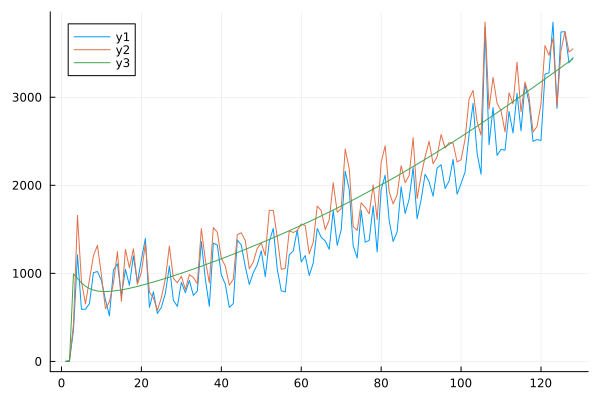

In [17]:
plot(cl2dl(Kl2Cl(result.draws[end-lmax:end,end], comm, root=0), 0))
plot!(cl2dl(Kl2Cl(vec(median(samples_MCHMC[end-3-lmax:end-3,:], dims=2)), comm, root=0), 0))
plot!(cl2dl(realiz_Cl,0))

In [12]:
PF_start_θ = result.draws[:,end]
struct LogTargetDensity
    dim::Int
end

LogDensityProblemsAD.logdensity(p::LogTargetDensity, θ) = -nℓπ(θ)
LogDensityProblemsAD.dimension(p::LogTargetDensity) = p.dim
LogDensityProblemsAD.capabilities(::Type{LogTargetDensity}) = LogDensityProblemsAD.LogDensityOrder{1}()

ℓπ = LogTargetDensity(d)
n_samples, n_adapts = 1_100, 100

metric = DiagEuclideanMetric(d)
ham = Hamiltonian(metric, ℓπ, Zygote)
initial_ϵ = find_good_stepsize(ham, PF_start_θ)
integrator = Leapfrog(initial_ϵ)

kernel = HMCKernel(Trajectory{MultinomialTS}(integrator, GeneralisedNoUTurn()))
adaptor = StanHMCAdaptor(MassMatrixAdaptor(metric), StepSizeAdaptor(0.9, integrator))

MPI.Barrier(comm)
t0 = time()
samples_NUTS, stats_NUTS = sample(ham, kernel, PF_start_θ, n_samples, adaptor, n_adapts; progress=true, verbose=true, drop_warmup = true)
MPI.Barrier(comm)
NUTS_t = time() - t0

2mSampling   0%|                               |  ETA: 0:21:27











































































































































































































































































































































































































































































































































































































































































































































































































































































































































































5448.190139055252

In [13]:
NUTS_ess, NUTS_rhat = Summarize(samples_NUTS)

([9.865819382738792, 14.883469128600446, 27.969326606567673, 13.935814416437085, 15.509017702122021, 5.68569410182977, 20.889767692101227, 11.330404452674633, 6.154231851157228, 16.707216741723695  …  682.4898778348122, 830.0485829331495, 967.3013167169249, 845.1295672766522, 701.4500311676095, 690.0380247133251, 880.6309230525793, 916.2987626266516, 1047.7321602571728, 900.5230445687256], [1.1546850224196095, 1.123179402082515, 1.022158987233073, 1.0220877609903942, 1.0758686426702442, 1.1795674656651107, 1.020197140184296, 1.057280173060183, 1.181281182281058, 1.0863061330711663  …  1.0012971038142315, 1.0042254008998404, 1.003298268852691, 0.9995291177404745, 1.0022261340719303, 0.9992207601184517, 0.9997171487544416, 0.9998406434617626, 0.9996050054787565, 1.0031327456925299])

In [19]:
mean(NUTS_ess)/NUTS_t

0.034584926253793724

In [21]:
50/120

0.4166666666666667

In [33]:
mean(NUTS_ess)/sum(2 .^ [stats_NUTS[i][:tree_depth] for i in 1:1_000])

0.00018400903728112505

In [ ]:
50/10_000

In [3]:
pf = npzread("MPI_chains/F7Tcj_PATHinit_$(nside).npy")

16512×10 Matrix{Float64}:
   6.47763      6.50723      6.49517    …    6.54714      6.41973
   0.0254732    0.0713453    0.052828        0.0562815    0.0740101
  -2.74184     -2.71412     -2.70957        -2.68264     -2.69585
  -1.59762     -1.60629     -1.59184        -1.58478     -1.55803
 -17.1095     -17.1637     -17.1324        -17.1435     -17.0873
 -18.7156     -18.7181     -18.7239     …  -18.7411     -18.6923
   1.72476      1.73166      1.7164          1.72353      1.69771
   0.0548843    0.0195975    0.0133667       0.0137591    0.0664844
  14.9001      14.8431      14.8709         14.9023      14.8492
  13.943       13.9179      13.9155         13.9385      13.9128
   ⋮                                    ⋱               
  -3.14184     -3.14206     -3.1376         -3.15878     -3.1807
  -3.09763     -3.10756     -3.07239        -3.09342     -3.10577
  -3.09863     -3.10038     -3.09055    …   -3.09089     -3.11112
  -3.10222     -3.11557     -3.08884        -3.0741      -3.

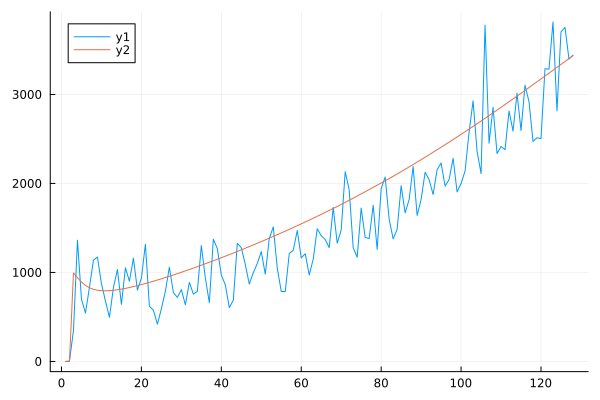

In [10]:
plot(cl2dl(Kl2Cl(pf[end-lmax:end,end], comm), 0))
plot!(cl2dl(realiz_Cl, 0))

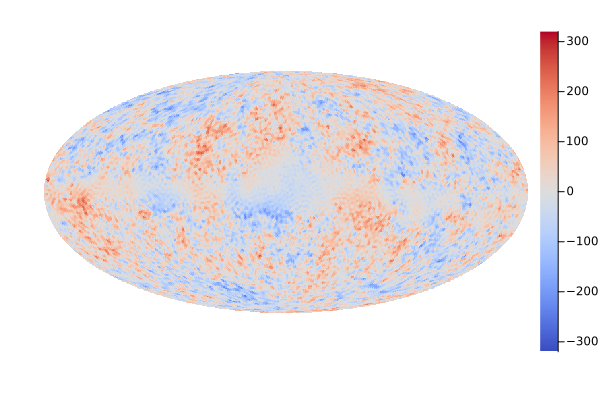

In [14]:
plot(Healpix.alm2map(from_alm_to_healpix_alm(x_vec2vecmat(pf[1:end-lmax-1,end], lmax, 1), lmax, 1)[1], nside),
color=:coolwarm, clim=(-320,320))

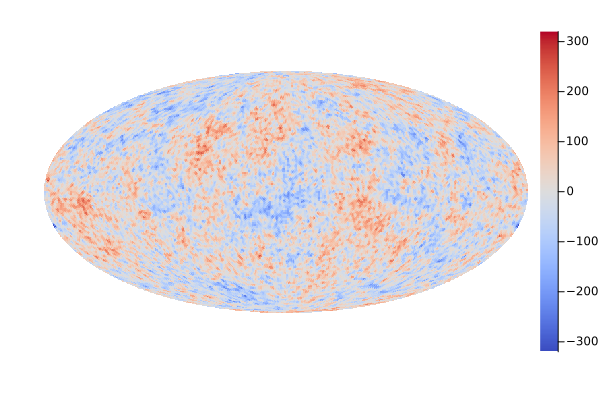

In [15]:
plot(realiz_HMap,
color=:coolwarm, clim=(-320,320))